# Eigenvalue solving

This introduction to eigenvalue solving will help us to compute the eigenvalues of the stiffness matrices previously defined.
The following is greatly inspired from Ian Hawke's course on numerical methods: https://github.com/IanHawke/NumericalMethods/blob/master/Lectures/

In [150]:
%matplotlib inline

In [181]:
import numpy as np
from scipy import linalg
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams.update({'font.size': 14})

## Revision

### Eigenvalues

$
\newcommand{\bx}{\boldsymbol{x}}
$

Eigenvalues, $\lambda$ and their corresponding eigenvectors
$\boldsymbol{u}$ are non-zero solutions to the linear system

$$A\boldsymbol{u} = \lambda \boldsymbol{u}.$$

Matrix eigenvalues and eigenvectors are of significant importance in physics. Notably in numerical engineering where they give informations about critical buckling loads or natural frequencies of a structure. 

### Eigenvalues and polynomials

Standard definition of eigenvalues: the $n$ roots of the *characteristic
polynomial*

$$\det ( A - \lambda I) = 0.$$

Could compute roots e.g. by nonlinear root finding.

There are two essential problems with this:

1.  Polynomials may be *badly conditioned*: a small change in the
    coefficients leads to a large change in the roots.

2.  Frequently do not need all eigenvalues, but only the largest one(s).
    Computing all, and then sorting, excessively expensive.


A $1\%$ change in the last coefficient leads to massive changes for

$$p(z) = -120 + 274 z - 225 z^2 + 85 z^3 -15 z^4 + z^5;$$

the roots $(4, 5)$ become $(4.580 \pm 0.966 \sqrt{-1})$.

In the following, we will see to type of methods called iterative methods:

1. The power method is a classic method to find the largest, or smallest, or closest eigenvalue of a matrix

2. The QR algorithm introduced by Francis is an iterative method that computes all the eigenvalues and eigenvectors of a matrix.

# The power method

The idea is to compute the largest eigenvalue without relying on characteristic polynomial. Look at what happen if we successively apply a matrix $A$ on a vector ${\boldsymbol{x}}$ representing a unit circle:

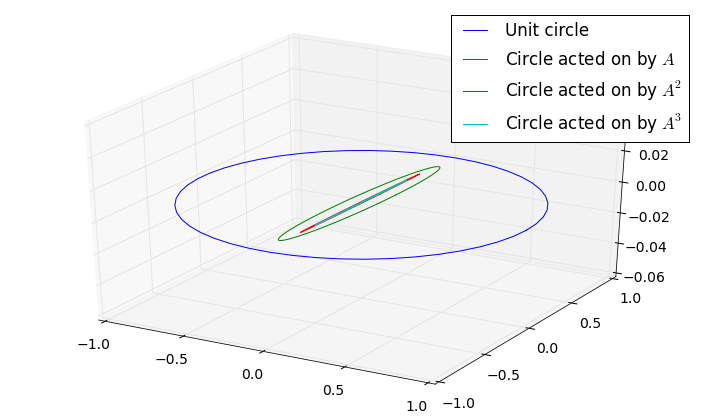

In [152]:
theta = np.linspace(0.0, 2.0*np.pi)
X = np.zeros((5,2,len(theta)))
X[0,0,:] = np.cos(theta)
X[0,1,:] = np.sin(theta)
A = np.random.rand(2,2)
for n in range(4):
    for i in range(len(theta)):
        X[n+1,:,i] = np.dot(A, X[n,:,i])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[0,0,:], X[0,1,:], label='Unit circle')
ax.plot(X[1,0,:], X[1,1,:], label=r"Circle acted on by $A$")
ax.plot(X[2,0,:], X[2,1,:], label=r"Circle acted on by $A^2$")
ax.plot(X[3,0,:], X[3,1,:], label=r"Circle acted on by $A^3$")
ax.legend()
fig.tight_layout()
plt.show()

The successive operations picks out a principal direction, i.e. an eigenvector.

## The power method: basis vectors

Key to power method: *assumption* that eigenvectors $\{
  {\boldsymbol{u}}_n \}$ form a basis of ${\mathbb C}^n$. If true,
repeated action of $A$ on *generic* vector ${\boldsymbol{x}}$ picks out
eigenvector with largest eigenvalue.

Specifically, construct sequence of vectors $\{ \bx^{(n)}
  \}$. Initial guess $\bx^{(0)}$ (nearly) arbitrary, members of sequence
are

$$\bx^{(k)} = A^k \bx^{(0)}.$$

Writing initial guess in terms of basis of eigenvectors shows

$$\bx^{(0)} = \sum_{j=1}^n a_j {\boldsymbol{u}}_j \, \implies \,
    \bx^{(k)} = \lambda_1^k \left[ a_1 {\boldsymbol{u}}_1 + \left(
        \frac{\lambda_2}{\lambda_1} \right)^{{k}} a_2 {\boldsymbol{u}}_2 + \dots + \left(
        \frac{\lambda_n}{\lambda_1} \right)^{{k}} a_n {\boldsymbol{u}}_n \right].$$

If $| \lambda_j / \lambda_1 | < 1 \quad \forall j > 1$ then the first
term dominates.

### Caution

Some points have been overlooked:

1.  Have assumed *unique* eigenvalue of maximum modulus.

2.  Have assumed the eigenvectors exist and are linearly independent.
    This is necessary to have a basis of eigenvectors.

3.  Have assumed the initial guess $\bx^{(0)}$ has a nonzero component
    in the direction of eigenvector ${\boldsymbol{u}}_1$; i.e. if

    $$\bx^{(0)} = \sum_{j=1}^n a_j {\boldsymbol{u}}_j \quad \implies \quad a_1 \neq 0.$$

    Not a major problem: repeated numerical operations have floating
    point error, so $a_1$ will never be *precisely* zero. Method
    converges faster the closer that $\bx^{(0)}$ is aligned with
    ${\boldsymbol{u}}_1$.

### Error terms

We can write the iterative method given by the power method as

$$\bx^{(k)} = \lambda_1^k \left( a_1 {\boldsymbol{u}}_1 + \epsilon^{(k)} \right)$$

where the term

$$\epsilon^{(k)} \equiv \sum_{j=2}^n \left(
      \frac{\lambda_j}{\lambda_1} \right)^k a_j {\boldsymbol{u}}_j$$

is expected to vanish in the limit. Explicitly,

$$\| \epsilon^{(k)} \| = {\cal O} \left( \left|
       \frac{\lambda_j}{\lambda_1} \right|^k \right)
   \xrightarrow[k \rightarrow \infty]{} 0.$$

In general expect the “error term” at each step to diminish by
$|\lambda_2 / \lambda_1|$, giving linear convergence, as seen later.

### Algorithm

The simplest (and not fully correct) algorithm defines the ratio

$$r_k = \frac{\| \bx^{(k+1)} \|}{\| \bx^{(k)} \|} = |\lambda_1|
    \frac{\| a_1 {\boldsymbol{u}}_1 + \epsilon^{(k+1)} \|}{\| a_1 {\boldsymbol{u}}_1 +
      \epsilon^{(k)} \|}.$$

From the convergence of the “error term” we then have that

$$\lim_{k\rightarrow\infty} r_k = | \lambda_1 |.$$

Algorithm is impractical: unless $\lambda_1$ is *extremely* close to 1,
iterates diverge to infinity or zero, spoiling accuracy. Instead
redefine members of sequence to have unit norm *after* computing the
ratio $r_k$:

1.  Pick $\bx^{(0)}$ such that $\|\bx^{(0)}\|=1$.

2.  For each $k$ compute $\bx^{(k+1)} = A \bx^{(k)}$.

3.  Compute $r_k = \| \bx^{(k+1)} \|$ (as $\| \bx^{(k)} \| = 1$).

4.  Re-normalize $\bx^{(k+1)}$. Repeat from (2).

### Example

The core of a simple  script for the power method:

    for k = 2 : niterations_max
        xn(:,k-1) = xn(:,k-1)./norm(xn(:,k-1));
        xn(:,k) = A * xn(:, k-1);
        rn(k) = norm(xn(:,k))./norm(xn(:,k-1));
        if (abs(rn(k) - rn(k-1)) < tol)
            break
        end
    end
    lambda = rn(k);

In Python, the function to perform the power method on a matrix $A$ would look like: 

In [153]:
def power_method(A, niterations_max = 50, tol = 1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.dot(A, xn[:,k])
        rn[k+1] = np.linalg.norm(xn[:,k+1])
        if (abs(rn[k+1]-rn[k]) < tol): 
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (rn[k+1], rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

Let's apply this algorithm on a matrix A:

In [154]:
A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,0.0]])
print(A)

[[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  0.]]


In [155]:
lamda, v = np.linalg.eig(A) # This is the built-in eigenvalue problem solver of Numpy
lamda_power, lamda_seq, vpm = power_method(A)
print("The maximum eigenvalue from the power method is {} (exact is {}, error is {})".format(lamda_power, np.max(lamda), 
                                                                                             abs(lamda_power - np.max(lamda))))
print("The associated eigenvector from the power method is {} (exact is {})".format(vpm, v[:,0]))

The maximum eigenvalue from the power method is 12.1228937846 (exact is 12.1228937846, error is 8.881784197e-15)
The associated eigenvector from the power method is [ 0.29982463  0.70747178  0.63999131] (exact is [-0.29982463 -0.70747178 -0.63999131])


We can plot the convergence of the power method algorithm:

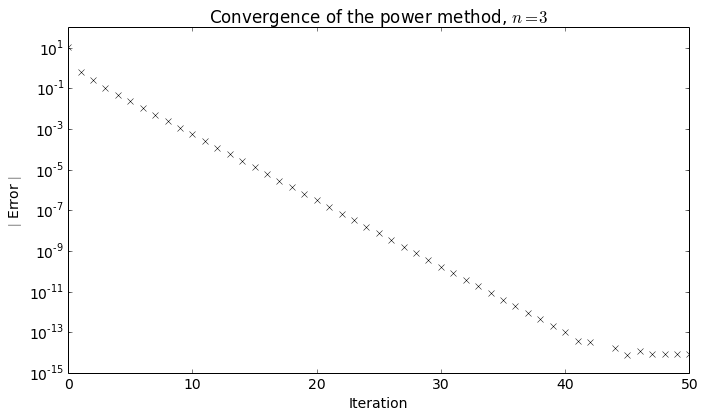

In [156]:
errors = np.abs(lamda_seq - np.max(lamda))
iterations = range(len(errors))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.semilogy(iterations, errors, 'kx')
ax.set_xlabel('Iteration')
ax.set_ylabel(r"$\|$ Error $\|$")
ax.set_title(r"Convergence of the power method, $n=3$")
fig.tight_layout()
plt.show()

## Phase information

### Beyond the absolute value

Although $\max |\lambda|$ is useful, it is straightforward to modify the power method
to compute the actual full value.

The eigenvalue is complex (in general), so in computing just the
*modulus*, we have lost information about the *phase*. Phase information is
lost when norms are computed. So the idea is to replace the norms with a different
*linear* functional $\phi: {\mathbb C}^n
  \rightarrow {\mathbb R}$.

Then we have

$$r_k = \frac{\phi(\bx^{(k+1)})}{\phi(\bx^{(k)})} = \lambda_1
    \frac{ a_1 \phi({\boldsymbol{u}}_1) + \phi(\epsilon^{(k+1)})}{ a_1 \phi( {\boldsymbol{u}}_1) +
      \phi(\epsilon^{(k)})};$$

which depends on the linearity of $\phi$. In the limit we eventually get the full eigenvalue
$\lambda_1$.

One possible choice for $\phi$ is to simply sum the components of $\bx$.
In all cases, care must be taken to avoid dividing by zero.

### Example

We apply the power method to the matrix

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix}.$$

The result converges linearly to find $\lambda = 12.1229$.

Identical convergence is seen for $-A$.

In [157]:
def full_power_method(A, niterations_max=50, tol=1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.dot(A, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (rn[k+1], rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

In [158]:
A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,0.0]])
lamda, v = np.linalg.eig(A)
lamda_power, lamda_seq, vpm = full_power_method(A)
print("The maximum eigenvalue from the power method is {} (exact is {}, error is {})".format(lamda_power, np.max(lamda), 
                                                                                             abs(lamda_power - np.max(lamda))))
lamda, v = np.linalg.eig(-A)
lamda_power, lamda_seq,vpm = full_power_method(-A)
print("For -A, maximum eigenvalue from the power method is {} (exact is {}, error is {})".format(lamda_power, np.min(lamda), 
                                                                                             abs(lamda_power - np.min(lamda))))

The maximum eigenvalue from the power method is 12.1228937846 (exact is 12.1228937846, error is 8.881784197e-15)
For -A, maximum eigenvalue from the power method is -12.1228937846 (exact is -12.1228937846, error is 8.881784197e-15)


## Convergence

### Rate of convergence

Look at behaviour near solution using Taylor’s theorem.

Start by defining $\mu = \lambda_2 / \lambda_1$. Use as “small
parameter” in expansion. Note that

$$\left| \frac{\lambda_j}{\lambda_1} \right|  < |\mu| \quad \forall
    j > 2.$$

Rewrite ratio as

$$r_k =  \lambda_1
    \frac{ a_1 \phi({\boldsymbol{u}}_1) + \phi(\epsilon^{(k+1)})}{ a_1
      \phi( {\boldsymbol{u}}_1) + \phi(\epsilon^{(k)})} = \lambda_1 \left[
      1 - \phi (\epsilon^{(k)}) \right] + {\cal O} (\mu^{k+1}).$$

The relative error is then

$$E^{(k)} = \left| \frac{r_k - \lambda_1}{\lambda_1} \right|    
    = \left| \phi( \epsilon^{(k)} ) \right|  + {\cal O}
    (\mu^{k+1}) 
    = c_k \mu^k$$

since $\epsilon^{(k)} \equiv \sum_{j=2}^n \left(
      \frac{\lambda_j}{\lambda_1} \right)^k a_j {\boldsymbol{u}}_j$. Hence we have a linear decrease at each stage of a factor $\mu$.

### Example revisited

The matrix

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix}$$

has eigenvalues

$$\left\{
          \begin{array}{c}
            12.1229\\ -5.7345\\ -0.3884
          \end{array}\right. .$$

Therefore the slope of the line should be $\log(|\mu|) \simeq -0.748593$; the actual best fit line used (carefully excluding endpoints!) had slope $-0.748590$.

In [159]:
lamda_sorted = np.sort(np.abs(lamda))
slope = np.log(lamda_sorted[-2]/lamda_sorted[-1])

p = np.polyfit(iterations[5:35], np.log(errors[5:35]), 1)

print("Expected slope is {}; measured slope is {}.".format(slope, p[0]))

Expected slope is -0.748593416673; measured slope is -0.748558030785.


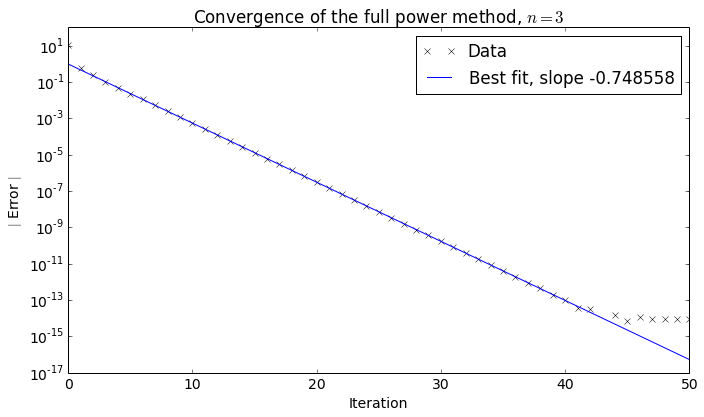

In [160]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.semilogy(iterations, errors, 'kx', label = 'Data')
ax.semilogy(iterations, np.exp(np.array(iterations)*p[0]+p[1]), 'b-', label = r"Best fit, slope {:2f}".format(p[0]))
ax.set_xlabel('Iteration')
ax.set_ylabel(r"$\|$ Error $\|$")
ax.set_title(r"Convergence of the full power method, $n=3$")
ax.legend()
fig.tight_layout()
plt.show()

## Variants on the power method

### The power method revisited

We are interested in computing the eigenvalues (and vectors) of a
general matrix, which may be very large.

The power method gave the largest eigenvalue, in absolute magnitude, as
long as it is unique and the eigenvectors are independent. It did this
by constructing a sequence, multiplying each time by the matrix $A$ and
normalizing.

This is a very simple method, and when we only need the largest
eigenvalue (e.g., for computing the spectral radius) gives exactly what
we need.

There may be times where we need different information. Provided it is
still only one eigenvalue that we are trying to find, there are variants
on the power method that can be used.

### Inverse power method

E.g. want to find the *smallest* eigenvalue. Important to find range of
scales in problem – problems with wildly varying scales difficult to
solve numerically.

Use:

$$\lambda_i \text{ are eigenvalues of } A \Rightarrow
    1/\lambda_i \text{ are eigenvalues of } A^{-1}$$

So apply power method to inverse matrix:

$$A {\boldsymbol{x}}_{n+1} = {\boldsymbol{x}}_n.$$

Converges towards eigenvector whose eigenvalue has *minimum* modulus.
Again, normalize at each step.

Do *not* use $A^{-1}$ directly, but solve linear system; decomposition
methods particularly effective.

### Inverse power method example

The matrix

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix}$$

has eigenvalues

$$\left\{
          \begin{array}{c}
            12.1229\\ -5.7345\\ -0.3884
          \end{array}\right. .$$

The inverse power method shows linear convergence towards
$\lambda = -0.3884$.

In [161]:
def inverse_power_method(A, niterations_max=50, tol=1e-15):
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.linalg.solve(A, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (1.0/rn[k+1], 1.0/rn, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

In [162]:
A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,0.0]])
lamda, v = np.linalg.eig(A)
order = np.abs(lamda).argsort()
lamda = lamda[order]
lamda_power, lamda_seq, vpm = inverse_power_method(A)

print("The minimum eigenvalue from the inverse power method is {} (exact is {}, error is {})".format(lamda_power, lamda[0], 
                                                                                             abs(lamda_power - lamda[0])))
print("The associated eigenvector from the power method is {} (exact is {})".format(vpm, v[:,1]))

The minimum eigenvalue from the inverse power method is -0.388383842407 (exact is -0.388383842407, error is 2.77555756156e-16)
The associated eigenvector from the power method is [ 0.74706733 -0.65820192  0.09306254] (exact is [-0.74706733  0.65820192 -0.09306254])


### Shifted power method

Another minor variant allows us to find the eigenvalue closest to a
given complex number $\sigma$. We just have to make use of:

$$\lambda_i \text{ are eigenvalues of } A \Rightarrow
    \lambda_i - \sigma \text{ are eigenvalues of } A - \sigma
    \text{Id}$$

Therefore the smallest eigenvalue of $A - \sigma \text{Id}$ is the one
closest to $\sigma$; this is just an application of the inverse power
method.

### Shifted power method example

The matrix

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix}$$

has eigenvalues

$$\left\{
          \begin{array}{c}
            12.1229\\ -5.7345\\ -0.3884
          \end{array}\right. .$$

The shifted power method shows linear convergence to $\lambda =
      -5.7345$ for the eigenvalue closest to $-5$.

In [163]:
def shifted_power_method(A, sigma, niterations_max=50, tol=1e-15):
    Ashift = A - sigma * np.eye(len(A))
    xn = np.zeros((len(A), niterations_max+1))
    xn[:, 0] = np.ones((len(A),)) + 1e-7*np.random.rand(len(A))
    rn = np.ones((niterations_max+1,))
    for k in range(niterations_max):
        xn[:,k] = xn[:,k] / np.linalg.norm(xn[:,k])
        xn[:,k+1] = np.linalg.solve(Ashift, xn[:,k])
        rn[k+1] = np.sum(xn[:,k+1])/np.sum(xn[:,k])
        if (abs(rn[k+1]-rn[k]) < tol):
            break
    if k < niterations_max:
        rn[k+2:] = rn[k+1] # This ensures the later values are set to something sensible.
    return (1.0/rn[k+1] + sigma, 1.0/rn + sigma, xn[:,k+1]/ np.linalg.norm(xn[:,k+1]))

In [164]:
lamda_shift, lamda_seq, vpm = shifted_power_method(A, -5.0)

print("The eigenvalue closest to -5.0 from the shifted power method is {} (exact is {}, error is {})".format(lamda_shift, lamda[1], 
                                                                                             abs(lamda_shift - lamda[1])))
print("The associated eigenvector from the power method is {} (exact is {})".format(vpm, v[:,2]))

The eigenvalue closest to -5.0 from the shifted power method is -5.73450994223 (exact is -5.73450994223, error is 1.7763568394e-15)
The associated eigenvector from the power method is [ 0.27625411  0.38842554 -0.87909571] (exact is [-0.27625411 -0.38842554  0.87909571])


## Hotelling's deflation method

Suppose we have found the largest eigenvalue of the matrix $A$ with the power iiteration method, how do we find the second largest eigenvalue? One solution is, after finding the largest eigenvalue $\lambda_1$, to make it into the smallest by deflation and then go on to find the new largest one, let say $\lambda_2$.

Consider:

$$\left(A-\lambda_1\mathbf{u}_1\mathbf{u}_1^T\right)\mathbf{u}_j=A\mathbf{u}_j-\lambda_1\mathbf{u}_1\mathbf{u}_1^T\mathbf{u}_j=\lambda_j\mathbf{u}_j-\lambda_1\mathbf{u}_1\left(\mathbf{u}_1^T\mathbf{u}_j\right)$$

$$\text{If $j=1$ then:} \qquad \left(A-\lambda_1\mathbf{u}_1\mathbf{u}_1^T\right)\mathbf{u}_j=\lambda_1\mathbf{u}_1-\lambda_1\mathbf{u}_1\left(\mathbf{u}_1^T\mathbf{u}_1\right) = 0\mathbf{u}_1$$

$$\text{If $j\neq1$ then:} \qquad \left(A-\lambda_1\mathbf{u}_1\mathbf{u}_1^T\right)\mathbf{u}_j=\lambda_j\mathbf{u}_j-\lambda_1\mathbf{u}_1\left(0\right) = \lambda_j\mathbf{u}_j$$

thus, $\left(A-\lambda_1\mathbf{u}_1\mathbf{u}_1^T\right)$ has the same eigenvectors as $A$ and the same eigenvalues as $A$ except that the largest one has been replaced by $0$. Thus we can use the power method to find the next biggest one $\lambda_2$ and so on...

In [197]:
A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,0.0]])
lamda_power, lamda_seq, vpm = full_power_method(A)
B = np.matrix(A)-lamda_power*np.transpose(np.matrix(vpm))*np.matrix(vpm)
lamda, v = np.linalg.eig(B)
print("The new eigenvalues of the deflated matrix B are {}.".format(lamda))
lamda_power2, lamda_seq2, vpm2 = full_power_method(B)
print("The next eigenvalue with the highest magnitude computed with the power method is {}.".format(lamda_power2))

The new eigenvalues of the deflated matrix B are [ -5.66213743e-15  -3.88383842e-01  -5.73450994e+00].
The next eigenvalue with the highest magnitude computed with the power method is -5.73450994223.


# $QR$ factorisation

## The full spectrum of a matrix

Our aim is to compute the full spectrum of the square $n \times n$
matrix $A$; that is, we want to find all its eigenvalues.

Method: transform to a simpler problem that is straightforwardly solved.
E.g. transform $A$ to $B$ with same spectrum, but $B$ triangular:
eigenvalues of a triangular matrix are the diagonal coefficients.

Schur’s theorem shows that every matrix $A$ has a *similar* triangular
matrix $B$, but is not useful for finding the matrix in practice.

A decomposition method for a general (not necessarily square)
matrix is the *orthogonal factorisation*. $A$ is written as a product of matrices,
some of which are orthogonal (i.e. real – $Q^{\dagger} =
  Q^T$ – and unitary, $Q^{-1} = Q^{\dagger} = Q^T$).

Simple example: *Gram-Schmidt* $QR$-factorisation

$$A = Q R,$$

with $Q$ an orthogonal matrix (i.e. $Q^TQ=I$), $R$ upper triangular. $A$ and $R$ may be $m
  \times n$ matrices, but $Q$ is always square ($m \times m$).

If $A = QR$ with $Q$ unitary then

$$B = R Q = \left( Q^{\dagger} Q \right) R Q = Q^{\dagger} A Q$$

which is similar to $A$.

## Gram-Schmidt’s factorisation

Consider the Gram-Schmidt procedure, with the vectors to be considered in the process as columns of the matrix $A$. That is,

$$A = \left[ {\mathbf{a}}_1 \; | \; {\mathbf{a}}_2 \; | \; \cdots \; | \; {\mathbf{a}}_n \right].$$

Then,

$$\mathbf{u}_1 = \mathbf{a}_1, \qquad \mathbf{e}_1 = \frac{\mathbf{u}_1}{\|\mathbf{u}_1\|}$$

$$\mathbf{u}_2 = \mathbf{a}_2 - (\mathbf{a}_2.\mathbf{e}_1)\mathbf{e}_1 , \qquad \mathbf{e}_2 = \frac{\mathbf{u}_2}{\|\mathbf{u}_2\|}$$

$$\mathbf{u}_{k+1} = \mathbf{a}_{k+1} - (\mathbf{a}_{k+1}.\mathbf{e}_1)\mathbf{e}_1 - \cdots -  (\mathbf{a}_{k+1}.\mathbf{e}_k)\mathbf{e}_k, \qquad \mathbf{e}_{k+1} = \frac{\mathbf{u}_{k+1}}{\|\mathbf{u}_{k+1}\|}$$
        
Note that $\|\bullet\|$ is the $L_2$ norm.  

The resulting *QR* factorisation is

$$A=\left[ {\mathbf{a}}_1 \; | \; {\mathbf{a}}_2 \; | \; \cdots \; | \; {\mathbf{a}}_n \right]=\left[ {\mathbf{e}}_1 \; | \; {\mathbf{e}}_2 \; | \; \cdots \; | \; {\mathbf{e}}_n \right]
        \begin{pmatrix}
          \mathbf{a}_1.\mathbf{e}_1 & \mathbf{a}_2.\mathbf{e}_1 & \cdots & \mathbf{a}_n.\mathbf{e}_1 \\
          0 & \mathbf{a}_2.\mathbf{e}_2 & \cdots & \mathbf{a}_n.\mathbf{e}_2 \\
          \vdots & \vdots & \ddots & \vdots \\
          0 & 0 & \cdots & \mathbf{a}_n.\mathbf{e}_n
        \end{pmatrix}=QR.$$

Note that once we find $\mathbf{e}_1,\cdots,\mathbf{e}_n$, it is not hard to write the *QR* factorization.

## The $QR$ algorithm

$QR$ algorithm: iterative process that, in the limit, gives upper
triangular $A_{\infty}$ similar to $A$. Two steps at each iteration:

1.  Factorize $A_k$ using for example Gram-Scmidt's algorithm to get

    $$A_k = Q_k R_k.$$

2.  Compute the next guess $A_{k+1}$ using

    $$A_{k+1} = R_k Q_k.$$

From the definition

$$A_{k+1}  = R_k Q_k = Q_k^{\dagger} Q_k R_k Q_k = Q_k^{\dagger} A_k Q_k$$

so that all members of the sequence are similar.

Start sequence with $A_1 = A$; iterate sequence to produce a triangular
matrix. If $A_k$ upper triangular then $Q_k = I$: sequence has converged

$$\begin{aligned}
    A_{k+1} & = A_k .
  \end{aligned}$$

In [166]:
def gs_m(A):
    m,n= A.shape
    A= A.copy()
    Q= np.zeros((m,n))
    R= np.zeros((n,n)) 
    for k in range(n):
        uk = A[:,k]       
        for j in range(0,k):
            uk = uk - np.dot(A[:,k],Q[:,j])*Q[:,j]
            R[j,k] = np.dot(A[:,k],Q[:,j])          
        Q[:,k] = uk/np.linalg.norm(uk,2)
        R[k,k] = np.dot(A[:,k],Q[:,k])     
    return Q, R

### Example

We apply the $QR$ algorithm to

$$A =
    \begin{pmatrix}
      1 & 2 & 3 \\
      4 & 5 & 6 \\
      7 & 8 & 0
    \end{pmatrix}.$$

Start from $A_1 = A$, and at each stage we compute the
$QR$-factorisation, setting $A_{k+1}  = R_k Q_k$. We find

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix} \rightarrow 
        A_2 = 
        \begin{pmatrix}
          8.5909 &  -9.2413  &  3.1659\\
          -4.3423 &  -1.0909 &   1.1078\\
          3.1659  &  1.1078 &  -1.5000
        \end{pmatrix}$$

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix} \rightarrow 
        A_3 = 
        \begin{pmatrix}
          12.1434 &  -0.1941 &   2.7400 \\
          3.6616 &  -5.8055 &   1.3022 \\
          0.1341 &  -0.2284 &  -0.3379
        \end{pmatrix}$$

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix} \rightarrow 
        A_4 = 
        \begin{pmatrix}
          11.6370 &  -5.3339 &  -3.0770\\
          -1.5849 &  -5.2507 &  -0.6576\\
          0.0041  &  0.0146  & -0.3863
        \end{pmatrix}$$

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix} \rightarrow 
        A_5 = 
        \begin{pmatrix}
          12.2535 &  -2.9417 &   2.9725\\
          0.7988  & -5.8653  &  1.0822\\
          0.0001  & -0.0011  & -0.3882
        \end{pmatrix}$$

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix} \rightarrow 
        A_6 = 
        \begin{pmatrix}
          12.0378 &  -4.1083 &  -3.0373\\
          -0.3683 &  -5.6494 &  -0.8874\\
          0.0000  &  0.0001  & -0.3884
        \end{pmatrix}$$

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix} \rightarrow 
        A_7 = 
        \begin{pmatrix}
          12.1581 &  -3.5634 &   3.0087 \\
          0.1765  & -5.7697  &  0.9800 \\
          0.0000  & -0.0000  & -0.3884
        \end{pmatrix}$$

The matrix

$$A =
        \begin{pmatrix}
          1 & 2 & 3 \\
          4 & 5 & 6 \\
          7 & 8 & 0
        \end{pmatrix}$$

has eigenvalues

$$\left\{
          \begin{array}{c}
            12.1229\\ -5.7345\\ -0.3884
          \end{array}\right. .$$

In [167]:
#This algorithm computes eigenvectors for symmetric matrices only
#For non Hermitian matrices, we need to use backward substitution with Schur vetors which is too compliated here...
def qr_algo(A, niterations_max=100, tol=1e-15):
    B = np.copy(A)
    Uk = np.identity(len(A))
    evals_approx = np.zeros((len(A),niterations_max))
    evals_approx[:,0] = np.diag(A)
    err = 1.0
    n = 0
    while err > tol and n < niterations_max-1:
        Q, R = np.linalg.qr(B)
        #Q, R  = gs_m(B)
        B = np.dot(R, Q)
        Uk = np.dot(Uk,Q)
        err = np.linalg.norm(np.tril(B, -1))
        n += 1
        evals_approx[:,n]=np.diag(B)
    return np.diag(B), Uk, evals_approx

In [168]:
A = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,0.0]])
lamda, v = np.linalg.eig(A)
lamda_qr, vqr, lamda_seq = qr_algo(A)
print("QR gives eigenvalues of {}. Exact are {}.".format(lamda_qr, lamda))
print("QR gives eigenvectors of {}. Exact are {})".format(vqr, v))
#
TT = np.diag(lamda_qr)
print("\n")
print(np.dot(A,vqr))
print("\n")
print(np.dot(vqr,TT))
print("\n")
print(np.dot(np.transpose(A),A))
print(np.dot(A,np.transpose(A)))

QR gives eigenvalues of [ 12.12289378  -5.73450994  -0.38838384]. Exact are [ 12.12289378  -0.38838384  -5.73450994].
QR gives eigenvectors of [[ 0.29982463 -0.34504083  0.88941105]
 [ 0.70747178 -0.54502068 -0.44992903]
 [ 0.63999131  0.76413302  0.08069603]]. Exact are [[-0.29982463 -0.74706733 -0.27625411]
 [-0.70747178  0.65820192 -0.38842554]
 [-0.63999131 -0.09306254  0.87909571]])


[[ 3.63474211  0.85731687  0.23164107]
 [ 8.57660525  0.4795314   1.79217521]
 [ 7.75854663 -6.77545129  2.62644511]]


[[ 3.63474211  1.97864007 -0.34543288]
 [ 8.57660525  3.12542653  0.17474517]
 [ 7.75854663 -4.38192842 -0.03134103]]


[[ 66.  78.  27.]
 [ 78.  93.  36.]
 [ 27.  36.  45.]]
[[  14.   32.   23.]
 [  32.   77.   68.]
 [  23.   68.  113.]]


Carreful, the eigenvectors are not correct with this simple method!
They would be if the matrix $A$ was normal, i.e. if $A^*A = AA^*$ or in case of real matrices if $A^TA = AA^T$.
Fortunately for us, the matrices arising from structural mechanics modeling are usually normal and the QR algorithm would give us correct eigenvectors:

In [169]:
A = np.array([[12, 3, 4], [3, 167, 6], [4, 6, -41]])
print(np.dot(np.transpose(A),A))
print(np.dot(A,np.transpose(A)))
lamda, v = np.linalg.eig(A)
lamda_qr, vqr, lamda_seq = qr_algo(A)
print("QR gives eigenvalues of {}. Exact are {}.".format(lamda_qr, lamda))
print("QR gives eigenvectors of {}. Exact are {})".format(vqr, v))

[[  169   561   -98]
 [  561 27934   768]
 [  -98   768  1733]]
[[  169   561   -98]
 [  561 27934   768]
 [  -98   768  1733]]
QR gives eigenvalues of [ 167.23542891  -41.45943724   12.22400833]. Exact are [  12.22400833  -41.45943724  167.23542891].
QR gives eigenvectors of [[ 0.02006528 -0.07304327  0.99712691]
 [ 0.99937273 -0.02764348 -0.02213546]
 [ 0.0291809   0.99694559  0.07244278]]. Exact are [[ 0.99712691  0.07304327 -0.02006528]
 [-0.02213546  0.02764348 -0.99937273]
 [ 0.07244278 -0.99694559 -0.0291809 ]])


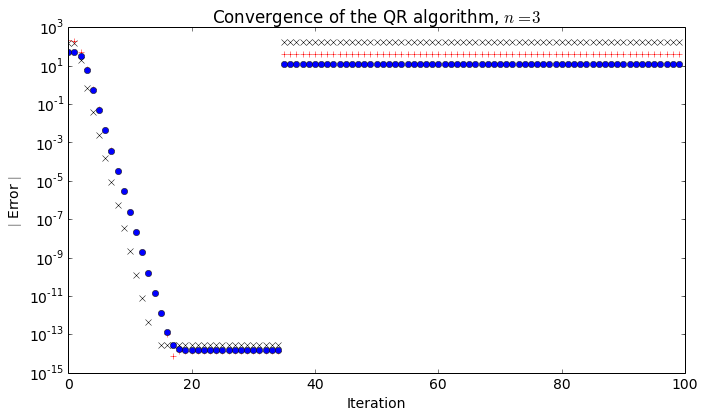

In [170]:
errors = np.zeros_like(lamda_seq)
errors[0,:] = np.abs(lamda_seq[0,:]-lamda[2])
errors[1,:] = np.abs(lamda_seq[1,:]-lamda[1])
errors[2,:] = np.abs(lamda_seq[2,:]-lamda[0])
iterations = range(errors.shape[1])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.semilogy(iterations, errors[0,:], 'kx')
ax.semilogy(iterations, errors[1,:], 'r+')
ax.semilogy(iterations, errors[2,:], 'bo')
ax.set_xlabel('Iteration')
ax.set_ylabel(r"$\|$ Error $\|$")
ax.set_title(r"Convergence of the QR algorithm, $n=3$")
fig.tight_layout()
plt.show()

## Generalized eigenvalue problem

$
\newcommand{\bx}{\boldsymbol{x}}
$

Many times in structural engineering, eigenvalue problems appear in their generalized form:

$$A\boldsymbol{u} = \lambda B\boldsymbol{u}.$$

The simplest way to solve a generalized eigenvalue problem is to recast it in the classic form:

$$C\boldsymbol{u} = \lambda \boldsymbol{u}$$

with $C=B^{-1}A$. Like in the inverse power method, do *not* use $B^{-1}$ directly, but solve linear system instead.

In [191]:
A = np.array([[12, 3, 4], [3, 167, 6], [4, 6, -41]])
B = np.array([[6, 2, 4], [3, 3, 5], [6, 32, -6]])
C = np.linalg.solve(B,A)
#C is not a normal matrix so we won't be able to compute all its eigenvectors
# either with classic QR-algorithm and 
print(np.dot(np.transpose(C),C))
print(np.dot(C,np.transpose(C)))
print("\n")
lamda, vl, vr = linalg.eig(A,B,left=True,right=True)
print("The eigenvalues of the generalized eigenvalue problem are {}.".format(lamda))
print("\n")

lamda_power1, lamda_seq1, vpm1 = full_power_method(C)

D = np.matrix(C)-lamda_power1*np.transpose(np.matrix(vpm1))*np.matrix(vpm1)
lamda_power2, lamda_seq2, vpm2 = full_power_method(D)

E = np.matrix(D)-lamda_power2*np.transpose(np.matrix(vpm2))*np.matrix(vpm2)
lamda_power3, lamda_seq3, vpm3 = full_power_method(E)

print("The eigenvalues of the generalized eigenvalue problem computed with the deflated power method are {},{},{}.".format(lamda_power1,lamda_power2,lamda_power3))
print("\n")

[[  7.51673095e+00  -1.28125363e+02  -1.69146006e+00]
 [ -1.28125363e+02   3.45815502e+03   8.40089532e+01]
 [ -1.69146006e+00   8.40089532e+01   4.49173554e+00]]
[[ 1203.87472911  -524.3653168  -1562.05898072]
 [ -524.3653168    229.82123967   680.64644628]
 [-1562.05898072   680.64644628  2036.46752066]]


The eigenvalues of the generalized eigenvalue problem are [  2.37221678+0.j   4.11223678+0.j  13.16403129+0.j].


The eigenvalues of the generalized eigenvalue problem computed with the deflated power method are 13.164031286,4.11223678341,2.37221677911.


